# Logistic regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn 
import seaborn as sns

## Loading the data

In [2]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/ChurnData.csv"
df=pd.read_csv(url)
df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,...,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,...,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,...,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,...,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,...,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,...,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0


## Description of dataset

This hypothetical dataset pertains to a telecommunications company's initiative to reduce customer churn. Each row represents a unique customer and includes 28 variables capturing demographic details (e.g. age, income, education), service usage metrics (e.g. tenure, call behaviour, internet use), and subscription features (e.g. wireless, call waiting, electronic billing). The target variable, **churn**, indicates whether the customer has left the service.

## Exploratory data analysis

array([[<Axes: title={'center': 'tenure'}>,
        <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'address'}>,
        <Axes: title={'center': 'income'}>,
        <Axes: title={'center': 'ed'}>,
        <Axes: title={'center': 'employ'}>,
        <Axes: title={'center': 'equip'}>],
       [<Axes: title={'center': 'callcard'}>,
        <Axes: title={'center': 'wireless'}>,
        <Axes: title={'center': 'longmon'}>,
        <Axes: title={'center': 'tollmon'}>,
        <Axes: title={'center': 'equipmon'}>,
        <Axes: title={'center': 'cardmon'}>,
        <Axes: title={'center': 'wiremon'}>],
       [<Axes: title={'center': 'longten'}>,
        <Axes: title={'center': 'tollten'}>,
        <Axes: title={'center': 'cardten'}>,
        <Axes: title={'center': 'voice'}>,
        <Axes: title={'center': 'pager'}>,
        <Axes: title={'center': 'internet'}>,
        <Axes: title={'center': 'callwait'}>],
       [<Axes: title={'center': 'confer'}>,
        <Axes: title=

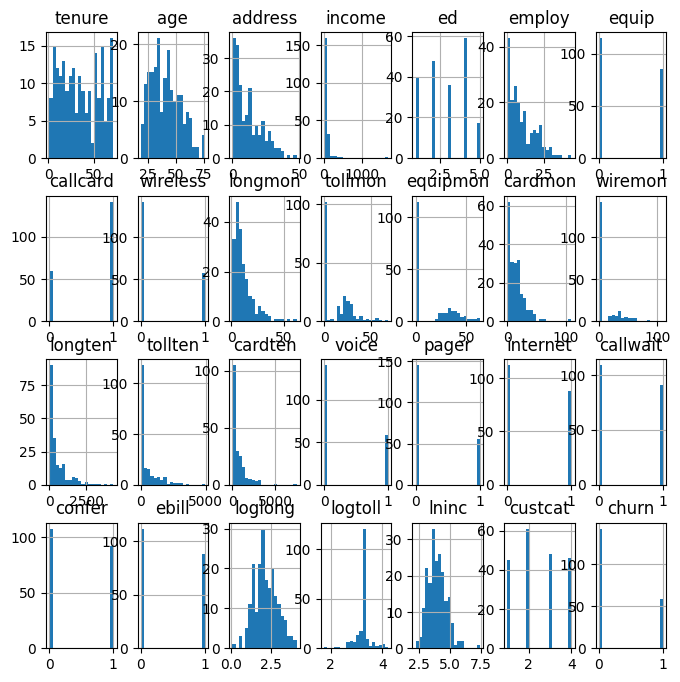

In [3]:
df.hist(figsize=(8,8),layout=(4,7),bins=20)

We observe that we have a mixture of binary variables and continuous variables. Our first job is to sort these cleanly. This mixture is not a problem in logistic regression, however, standardising the continuous variables will aid in interpreting the coefficients of the model and in the training process. Additionally, we should check for multicollinearity among the continuous variables before choosing our features.

#### Sorting

In [4]:
df_bin = df[[col for col in df.columns if df[col].dropna().nunique() == 2]]
df_cont = df[[col for col in df.columns if df[col].dropna().nunique() != 2]]

#### Standardisation

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_cont = pd.DataFrame(scaler.fit_transform(df_cont), columns=df_cont.columns, index=df_cont.index)

#### Multicollinearity


In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['Variable'] = df_cont.columns
vif_data['VIF'] = [variance_inflation_factor(df_cont.values, i) for i in range(df_cont.shape[1])]
print(vif_data)

    Variable         VIF
0     tenure   14.703747
1        age    2.969077
2    address    2.652110
3     income    1.933595
4         ed    1.668655
5     employ    2.680116
6    longmon  180.303958
7    tollmon   10.308396
8   equipmon    2.213162
9    cardmon   10.398346
10   wiremon    2.991991
11   longten  144.661688
12   tollten    9.199913
13   cardten   14.366388
14   loglong   29.498204
15   logtoll    1.618356
16     lninc    2.799192
17   custcat    2.782830


This tells us that tenure, longmon, tollmon, cardmon, longten, tollten, cardten, and loglong are highly redundant. Thus, we would like to remove them from the features.

In [7]:
high_vif_vars = ['tenure', 'longmon', 'tollmon', 'cardmon', 'longten', 'tollten', 'cardten', 'loglong']
df_cont = df_cont.drop(columns=high_vif_vars)

## Feature selection

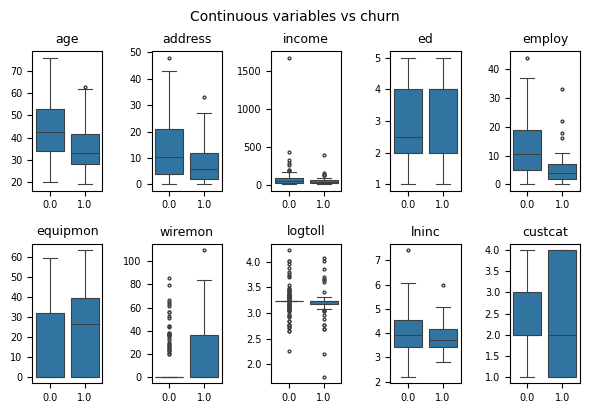

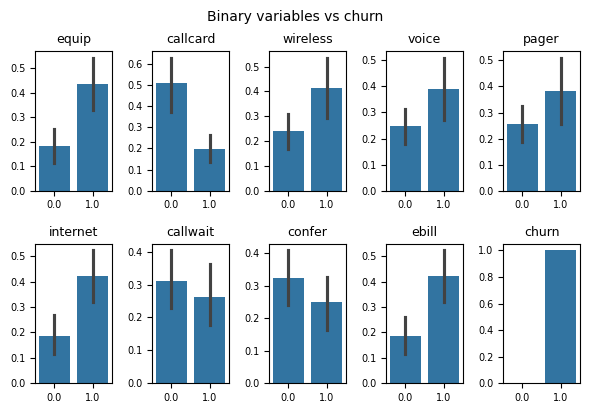

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplots for continuous variables 
fig, axes = plt.subplots(2, 5, figsize=(6, 4))
axes = axes.flatten()

for i, col in enumerate(df_cont.columns):
    sns.boxplot(x=df['churn'], y=df[col], ax=axes[i], linewidth=0.8, fliersize=2)
    axes[i].set_title(col, fontsize=9)
    axes[i].tick_params(labelsize=7)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Hide unused
for j in range(len(df_cont.columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.suptitle("Continuous variables vs churn", fontsize=10, y=1.02)
plt.savefig("../images/cont.png", bbox_inches='tight')
plt.show()

# Barplots for binary variables 
fig, axes = plt.subplots(2, 5, figsize=(6, 4))
axes = axes.flatten()

for i, col in enumerate(df_bin.columns):
    sns.barplot(x=col, y='churn', data=df, ax=axes[i])
    axes[i].set_title(col, fontsize=9)
    axes[i].tick_params(labelsize=7)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Hide unused
for j in range(len(df_bin.columns), len(axes)):
    axes[j].set_visible(False)
print('\n')
plt.tight_layout()
plt.suptitle("Binary variables vs churn", fontsize=10, y=1.02)
plt.savefig("../images/bin.png", bbox_inches='tight')
plt.show()

Binary variables vs churn:

Each bar chart shows the **mean churn rate** for two groups: customers without the feature (0) and with the feature (1). The y-axis represents the proportion of customers who churned. Error bars indicate variability (typically standard error) within each group. These plots help reveal whether the presence of a binary feature is associated with higher or lower churn.

Continuous variables vs churn :

Each boxplot compares the **distribution of a continuous variable** across churn categories (0 = no churn, 1 = churn). The box displays the interquartile range (IQR), the line inside the box is the median, and the whiskers extend to typical minimum and maximum values (excluding outliers). These plots highlight shifts in central tendency and spread between churners and non-churners, helping us assess how a given continuous variable relates to churn status.

#### Feature selection based on the EDA

The following continuous variables show **clear separation** in distribution between churned and non-churned customers, suggesting that they do have a non-insignificant relationship with the churn:

- **`income`**: Churners have notably lower income
- **`lninc`**: Log-transformed income shows the same pattern with cleaner spread
- **`employ`**: Fewer years employed associated with higher churn
- **`address`**: Shorter address tenure correlates with churn
- **`custcat`**: Distinct shifts across churn classes, behaves like an ordinal predictor

The following binary variables exhibit **substantial differences** in churn rate between their 0/1 categories:

- **`callcard`**: Customers with a calling card plan churn less
- **`equip`**: Equipment plan holders are less likely to churn
- **`internet`**: Internet subscription is associated with reduced churn
- **`ebill`**: Use of electronic billing predicts lower churn
- **`wireless`**: Wireless service subscribers show reduced churn

We will select **employment**, **lninc** and **address** from the continuous variables and **ebill**, **callcard** from the binary and create a model for predicting the churn likelihood based on these features.

## Model development


Intercept: -0.74
Test Log-loss: 0.5383
Cross-validated Log-loss (5-fold): 0.5022

    Feature  Coefficient  Odds ratio
0    employ      -1.2630      0.2828
1     lninc       0.5534      1.7391
2   address      -0.2591      0.7718
3     ebill       0.6149      1.8494
4  callcard      -1.1423      0.3191


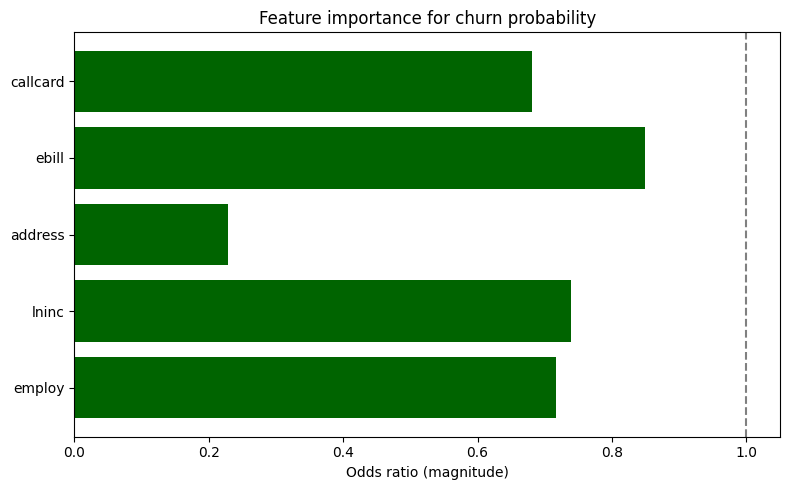

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, make_scorer
import numpy as np
import pandas as pd

# Merge the features and targets into one dataframe
df_model = pd.concat([ 
    df_cont[['employ', 'lninc', 'address']], 
    df_bin[['ebill', 'callcard', 'churn']]
], axis=1)

X = np.asarray(df_model[['employ', 'lninc', 'address', 'ebill', 'callcard']])
y = np.asarray(df_model['churn'])

# Train-test split (order does not matter since we are not working with sequential data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Fit model
LR = LogisticRegression()
LR.fit(X_train, y_train)
predictions = LR.predict(X_test)
probabilities = LR.predict_proba(X_test)[:, 1]

# Coefficients
coefficients = LR.coef_[0]
intercept = LR.intercept_[0]
feature_names = ['employ', 'lninc', 'address', 'ebill', 'callcard']

# Log loss (on test set)
logloss = log_loss(y_test, probabilities)

# Cross-validated log loss
cv_scores = cross_val_score(LR, X, y, cv=5, scoring='neg_log_loss')
avg_logloss_cv = -cv_scores.mean()  # negate since scoring returns negative

# Results table
results = []
for i, feature in enumerate(feature_names):
    results.append({
        'Feature': feature,
        'Coefficient': round(coefficients[i], 4),
        'Odds ratio': round(np.exp(coefficients[i]), 4)
    })

# Output
print(f'Intercept: {intercept:.2f}')
print(f'Test Log-loss: {logloss:.4f}')
print(f'Cross-validated Log-loss (5-fold): {avg_logloss_cv:.4f}\n')
print(pd.DataFrame(results))


# Plot odds ratios
odds_ratios = np.abs(1-np.exp(coefficients))
plt.figure(figsize=(8, 5))
plt.barh(feature_names, odds_ratios, color='darkgreen')
plt.axvline(1, color='grey', linestyle='--')
plt.xlabel('Odds ratio (magnitude)')
plt.title('Feature importance for churn probability')
plt.tight_layout()
plt.savefig("../images/odds-ratio.png")
plt.show()


The table of coefficients (converted to odds ratios) reveals the following:

- **`callcard` (OR = 0.32)**  
  Customers with a calling card plan are **68% less likely to churn**. This was the strongest negative predictor and likely represents a service that increases customer engagement or lock-in.

- **`employ` (OR = 0.28)**  
  Longer employment duration is associated with a **72% reduction in churn odds** per additional year. This effect is stronger than previously estimated, reinforcing the idea that job stability correlates with customer loyalty.

- **`address` (OR = 0.77)**  
  Customers who have lived longer at their current address are **23% less likely to churn**. This suggests geographic or residential stability may correspond to lower churn risk.

- **`lninc` (OR = 1.74)**  
  Higher log-income is associated with a **74% increase in churn odds**. This may indicate that wealthier customers are more mobile, more attractive to competitors, or more sensitive to service quality.

- **`ebill` (OR = 1.85)**  
  Use of electronic billing corresponds to an **85% increase in churn odds**. This counterintuitive result may reflect the characteristics of digitally active customers, e.g. those more willing to switch or experiment with providers.

- The **intercept = –0.74** corresponds to a **baseline churn probability of \~32%**, representing the expected likelihood of churn for a customer with all features set to zero (e.g. no employment, minimal income, no e-billing, etc.). While the baseline customer is hypothetical, the intercept suggests that churn is a material risk even in the absence of known predictors. This reflects both the irrationality of human decision making and the complexity of most people's lives.

This model highlights that **service-specific features** (`callcard`, `ebill`) exert stronger influence than static demographics. The relatively low **cross-validated log loss** suggests good calibration and generalisability.

However, the model is still linear. Further performance improvements may come from using **non-linear models** (e.g. random forests, gradient boosting) to better capture interaction effects and non-linear patterns since redundant and ephemeral features have been removed.
